<a href="https://colab.research.google.com/github/gabe-hi/Breast_Cancer_CNN/blob/Austin_workspace/benign_malignant_network_build/EfficientNetB0main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
from google.colab import drive
drive.mount('/content/drive')

data_dir = '/content/drive/My Drive/benign_malignant_network_build'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os

import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

import random
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("TensorFlow version:", tf.__version__)

# Configure memory growth for GPU if available
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPU")
    except RuntimeError as e:
        print("Memory growth setting failed:", e)

GPU Available:  []
TensorFlow version: 2.17.0


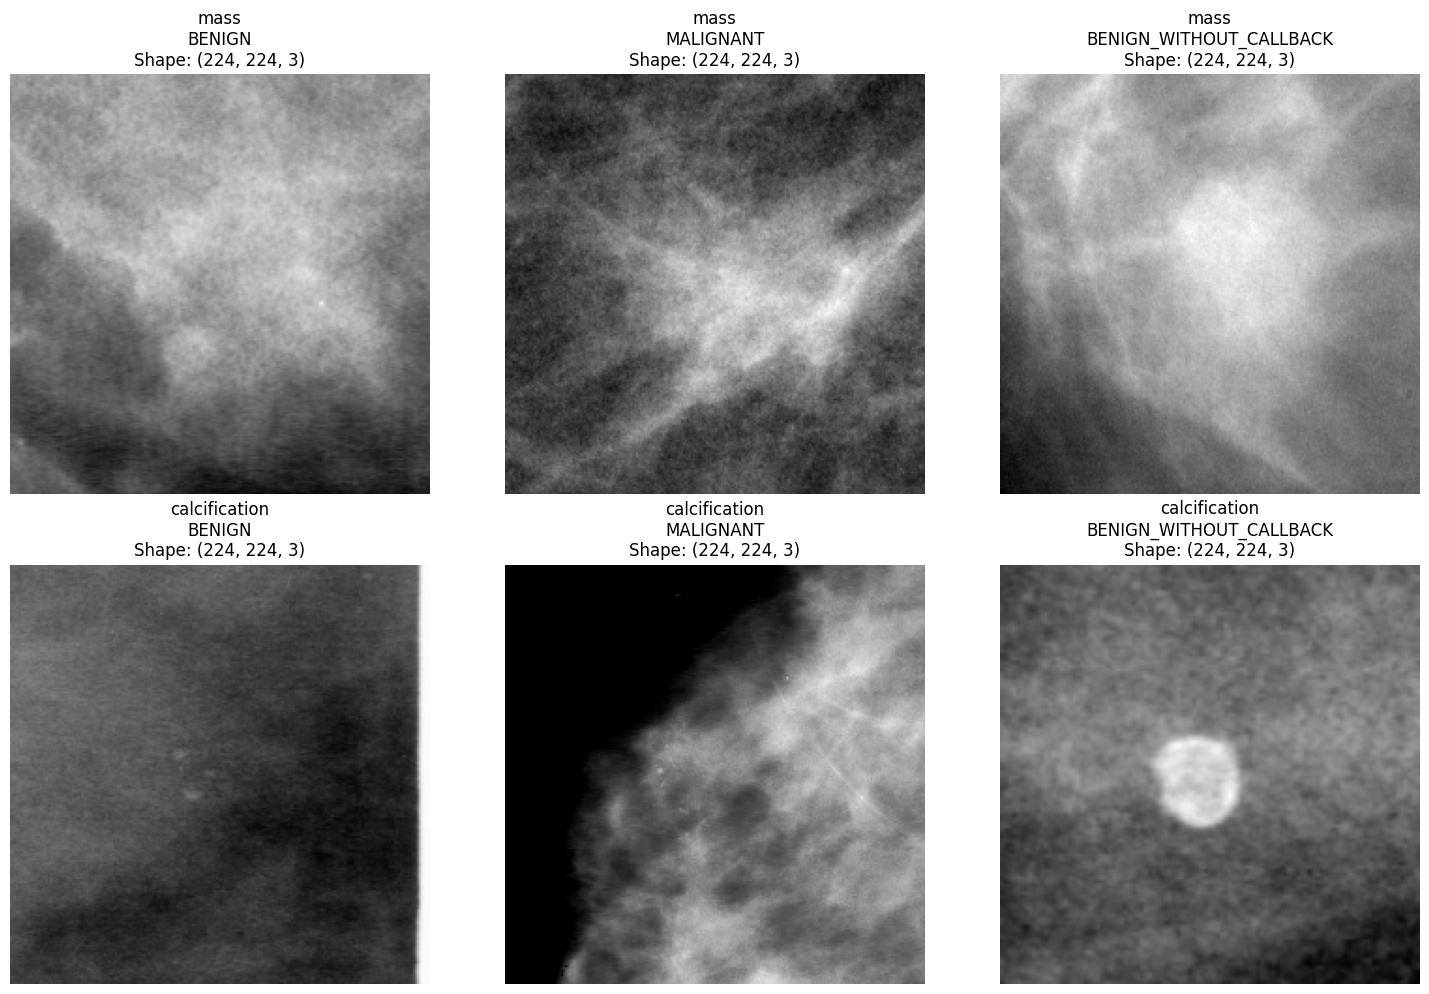

In [35]:
def display_sample_images(base_path, num_samples=3):
    categories = ['BENIGN', 'MALIGNANT', 'BENIGN_WITHOUT_CALLBACK']
    types = ['mass', 'calcification']

    fig = plt.figure(figsize=(15, 10))

    for type_idx, type_name in enumerate(types):
        for cat_idx, category in enumerate(categories):
            plot_idx = type_idx * len(categories) + cat_idx + 1

            path = os.path.join(base_path, type_name, 'train', 'cropped_files', category)
            try:
                image_files = [f for f in os.listdir(path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
                if image_files:
                    img_file = np.random.choice(image_files)
                    img_path = os.path.join(path, img_file)

                    img = tf.keras.preprocessing.image.load_img(img_path)
                    img_array = tf.keras.preprocessing.image.img_to_array(img)

                    plt.subplot(2, 3, plot_idx)
                    plt.imshow(img_array.astype(np.uint8))
                    plt.title(f'{type_name}\n{category}\nShape: {img_array.shape}')
                    plt.axis('off')
            except Exception as e:
                print(f"Error processing {path}: {str(e)}")

    plt.tight_layout()
    plt.show()

display_sample_images(data_dir)

In [58]:
train_gen = image.ImageDataGenerator(
    dtype='float32',
    preprocessing_function=preprocess_input
)

test_gen = image.ImageDataGenerator(
    dtype='float32',
    preprocessing_function=preprocess_input
)

In [59]:
mass_train_generator = train_gen.flow_from_directory(
    os.path.join(data_dir, 'mass/train/cropped_files'),
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

mass_val_generator = test_gen.flow_from_directory(
    os.path.join(data_dir, 'mass/test/cropped_files'),
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

calc_train_generator = train_gen.flow_from_directory(
    os.path.join(data_dir, 'calcification/train/cropped_files'),
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

calc_val_generator = test_gen.flow_from_directory(
    os.path.join(data_dir, 'calcification/test/cropped_files'),
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

Found 626 images belonging to 3 classes.
Found 339 images belonging to 3 classes.
Found 749 images belonging to 3 classes.
Found 301 images belonging to 3 classes.


In [60]:
# First, calculate class weights for both models
def calculate_class_weights(generator):
    total_samples = len(generator.classes)
    n_classes = 3
    class_counts = np.bincount(generator.classes)
    class_weights = {
        i: total_samples / (n_classes * count)
        for i, count in enumerate(class_counts)
    }
    return class_weights

# Focal Loss implementation
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = 1e-7
        y_true = tf.cast(y_true, tf.float32)

        # Calculate cross entropy
        cross_entropy = -y_true * tf.math.log(y_pred + epsilon)

        # Calculate focal loss
        weight = tf.pow(1 - y_pred + epsilon, gamma)
        focal = alpha * weight * cross_entropy

        return tf.reduce_mean(tf.reduce_sum(focal, axis=-1))
    return focal_loss_fixed


In [61]:
def create_model(input_shape=(224, 224, 3), num_classes=3, model_type="mass"):
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    base_model.trainable = False

    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    x = tf.keras.layers.Dense(180)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.01)(x)

    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name=f'efficientnet_{model_type}')

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=focal_loss(gamma=2.0, alpha=0.25),  # Using focal loss
        metrics=['accuracy',
                tf.keras.metrics.AUC(),
                tf.keras.metrics.Precision(),
                tf.keras.metrics.Recall()]
    )

    return model


In [62]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        min_delta=0.001
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=4,
        min_lr=1e-6
    )
]

In [63]:
print("Training Mass Model...")
mass_class_weights = calculate_class_weights(mass_train_generator)
print("Mass Model Class Weights:", mass_class_weights)

mass_model = create_model(model_type="mass")
mass_history = mass_model.fit(
    mass_train_generator,
    validation_data=mass_val_generator,
    epochs=20,
    callbacks=callbacks,
    class_weight=mass_class_weights
)

Training Mass Model...
Mass Model Class Weights: {0: 0.7815230961298377, 1: 2.344569288389513, 2: 0.7728395061728395}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.5017 - auc_11: 0.6634 - loss: 0.1686 - precision_11: 0.5263 - recall_11: 0.3875 - val_accuracy: 0.5103 - val_auc_11: 0.7164 - val_loss: 0.1036 - val_precision_11: 0.5345 - val_recall_11: 0.1829 - learning_rate: 0.0010
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.6087 - auc_11: 0.7942 - loss: 0.1037 - precision_11: 0.6655 - recall_11: 0.4967 - val_accuracy: 0.5516 - val_auc_11: 0.7301 - val_loss: 0.1042 - val_precision_11: 0.6721 - val_recall_11: 0.1209 - learning_rate: 0.0010
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.6250 - auc_11: 0.8202 - loss: 0.0902 - precision_11: 0.7094 - recall_11: 0.5160 - val_accuracy: 0.5398 - val_auc_11: 0.7283 - val_loss: 0.1028 - val_precision_11: 0.7037 - val_recall_11: 0.1121 - learning_rate: 0.0010
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.6530 - auc_11: 0.8447 - loss: 0.0782 - precision_11: 0.7071 - recall_11: 0.5205 - val_accuracy: 0.5

In [49]:
mass_model.summary()

Model: "efficientnet_mass"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 7, 7, 1280)          │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_8           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 180)                 │         230,580 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 180)                 │             720 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_9 (LeakyReLU)            │ (None, 180)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 3)                   │             543 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,764,862 (18.18 MB)

 Trainable params: 236,603 (924.23 KB)

 Non-trainable params: 4,055,051 (15.47 MB)

 Optimizer params: 473,208 (1.81 MB)

In [50]:
print("\nTraining Calcification Model...")
calc_class_weights = calculate_class_weights(calc_train_generator)
print("Calcification Model Class Weights:", calc_class_weights)

calc_model = create_model(model_type="calcification")
calc_history = calc_model.fit(
    calc_train_generator,
    validation_data=calc_val_generator,
    epochs=20,
    callbacks=callbacks,
    class_weight=calc_class_weights
)


Training Calcification Model...
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


47/47 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.5287 - auc_10: 0.7319 - loss: 1.0742 - precision_10: 0.5409 - recall_10: 0.4409 - val_accuracy: 0.5681 - val_auc_10: 0.7733 - val_loss: 0.8943 - val_precision_10: 0.7976 - val_recall_10: 0.2226 - learning_rate: 0.0010
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.6569 - auc_10: 0.8607 - loss: 0.6929 - precision_10: 0.7080 - recall_10: 0.5974 - val_accuracy: 0.5748 - val_auc_10: 0.7904 - val_loss: 0.8603 - val_precision_10: 0.7358 - val_recall_10: 0.2591 - learning_rate: 0.0010
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7012 - auc_10: 0.8787 - loss: 0.6484 - precision_10: 0.7239 - recall_10: 0.6302 - val_accuracy: 0.5914 - val_auc_10: 0.7952 - val_loss: 0.8223 - val_precision_10: 0.6456 - val_recall_10: 0.3389 - learning_rate: 0.0010
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.7092 - auc_10: 0.8893 - loss: 0.6301 - precision_10: 0.7270 - recall_10: 0.6715 - val_accuracy: 0.574

In [52]:
calc_model.summary()

Model: "efficientnet_calcification"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 7, 7, 1280)          │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_9           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 180)                 │         230,580 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 180)                 │             720 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_10 (LeakyReLU)           │ (None, 180)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 3)                   │             543 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,764,862 (18.18 MB)

 Trainable params: 236,603 (924.23 KB)

 Non-trainable params: 4,055,051 (15.47 MB)

 Optimizer params: 473,208 (1.81 MB)

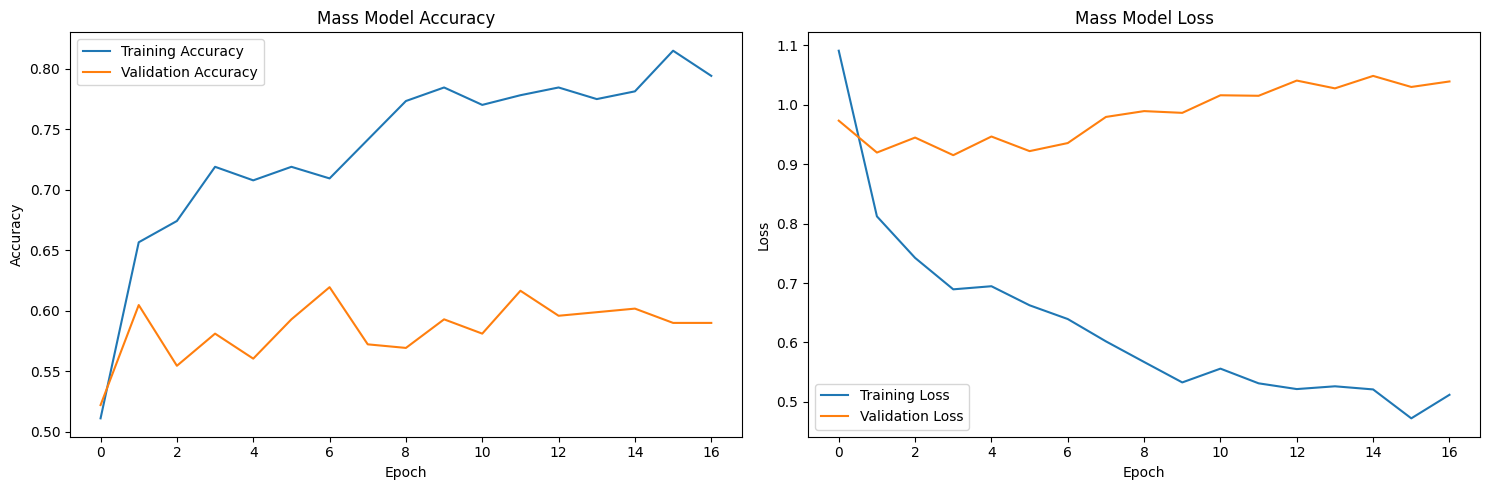

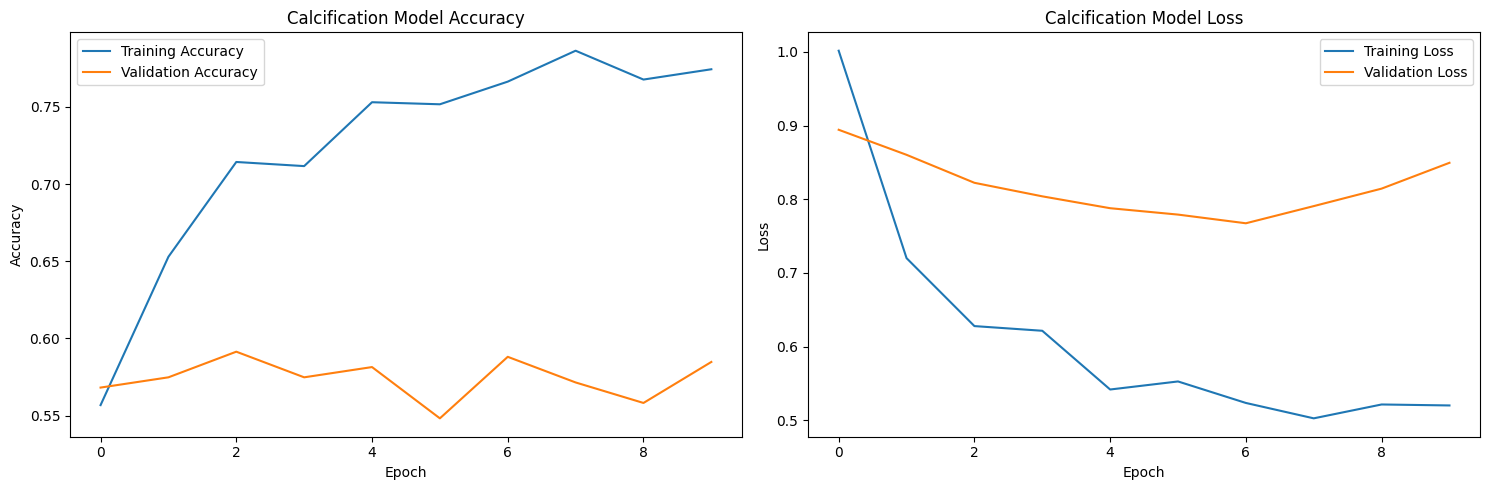

In [57]:
def plot_history(history, model_type):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title(f'{model_type} Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title(f'{model_type} Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()
    plt.show()

plot_history(mass_history, 'Mass')
plot_history(calc_history, 'Calcification')


In [54]:
def analyze_both_models(mass_model, calc_model, mass_val_gen, calc_val_gen):
    def analyze_single_model(model, generator, model_name):
        predictions = model.predict(generator)
        predicted_classes = np.argmax(predictions, axis=1)
        true_classes = generator.classes

        cm = confusion_matrix(true_classes, predicted_classes)

        unique, counts = np.unique(true_classes, return_counts=True)
        class_dist = dict(zip(unique, counts))

        print(f"\n=== {model_name} Model Analysis ===")
        print("\nConfusion Matrix:")
        print(cm)
        print("\nClass Distribution:")
        print(class_dist)

        misclassified = np.where(predicted_classes != true_classes)[0]
        print(f"\nNumber of misclassified samples: {len(misclassified)}")

        if len(misclassified) > 0:
            print("\nSample of misclassified cases:")
            for idx in misclassified[:3]:
                print(f"True class: {true_classes[idx]}")
                print(f"Predicted class: {predicted_classes[idx]}")
                print(f"Confidence: {np.max(predictions[idx])*100:.2f}%")
                print("---")

    analyze_single_model(mass_model, mass_val_gen, "Mass")
    analyze_single_model(calc_model, calc_val_gen, "Calcification")

analyze_both_models(mass_model, calc_model, mass_val_generator, calc_val_generator)

22/22 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step

=== Mass Model Analysis ===

Confusion Matrix:
[[91  8 66]
 [14  2 21]
 [76  7 54]]

Class Distribution:
{0: 165, 1: 37, 2: 137}

Number of misclassified samples: 192

Sample of misclassified cases:
True class: 0
Predicted class: 2
Confidence: 95.73%
---
True class: 0
Predicted class: 2
Confidence: 39.32%
---
True class: 0
Predicted class: 2
Confidence: 64.83%
---
19/19 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step

=== Calcification Model Analysis ===

Confusion Matrix:
[[16 39 62]
 [20 19 28]
 [19 35 63]]

Class Distribution:
{0: 117, 1: 67, 2: 117}

Number of misclassified samples: 203

Sample of misclassified cases:
True class: 0
Predicted class: 2
Confidence: 49.60%
---
True class: 0
Predicted class: 2
Confidence: 58.45%
---
True class: 0
Predicted class: 2
Confidence: 42.89%
---



Making predictions on test images...
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


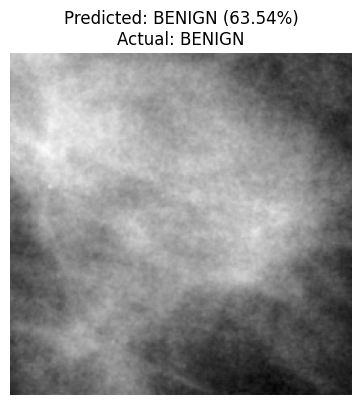

Test 1    Predicted: BENIGN (63.54%)    Actual: BENIGN
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


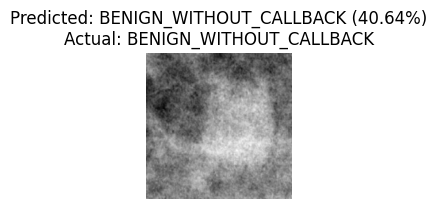

Test 2    Predicted: BENIGN_WITHOUT_CALLBACK (40.64%)    Actual: BENIGN_WITHOUT_CALLBACK
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


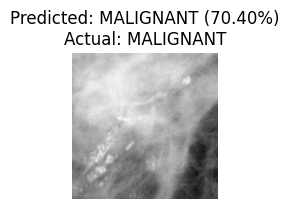

Test 3    Predicted: MALIGNANT (70.40%)    Actual: MALIGNANT


<Figure size 640x480 with 0 Axes>

In [55]:
prediction_labels = list(mass_val_generator.class_indices.keys())

benign_path = os.path.join(data_dir, 'mass/test/cropped_files/BENIGN/1-010.jpg')
bwc_path = os.path.join(data_dir, 'mass/test/cropped_files/BENIGN_WITHOUT_CALLBACK/1-050.jpg')
malignant_path = os.path.join(data_dir, 'mass/test/cropped_files/MALIGNANT/1-027.jpg')

def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_batch.copy())

def predict_and_display(model, image_path, actual_class):
    processed_img = load_and_preprocess_image(image_path)

    prediction = model.predict(processed_img)
    predicted_class = prediction_labels[np.argmax(prediction)]
    confidence = np.max(prediction) * 100

    img = image.load_img(image_path, target_size=(224, 224))
    plt.imshow(img)
    plt.title(f'Predicted: {predicted_class} ({confidence:.2f}%)\nActual: {actual_class}')
    plt.axis('off')
    plt.show()

    return predicted_class, confidence

print("\nMaking predictions on test images...")
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
predicted_class, confidence = predict_and_display(mass_model, benign_path, "BENIGN")
print(f"Test 1    Predicted: {predicted_class} ({confidence:.2f}%)    Actual: BENIGN")

plt.subplot(1, 3, 2)
predicted_class, confidence = predict_and_display(mass_model, bwc_path, "BENIGN_WITHOUT_CALLBACK")
print(f"Test 2    Predicted: {predicted_class} ({confidence:.2f}%)    Actual: BENIGN_WITHOUT_CALLBACK")

plt.subplot(1, 3, 3)
predicted_class, confidence = predict_and_display(mass_model, malignant_path, "MALIGNANT")
print(f"Test 3    Predicted: {predicted_class} ({confidence:.2f}%)    Actual: MALIGNANT")

plt.tight_layout()
plt.show()


Making predictions on calcification test images...
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


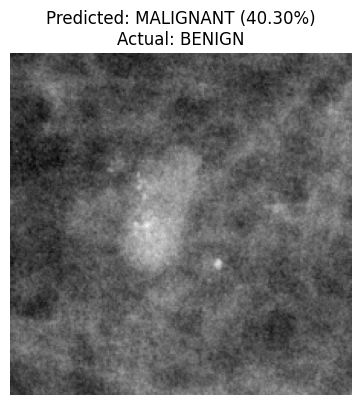

Calc Test 1    Predicted: MALIGNANT (40.30%)    Actual: BENIGN
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


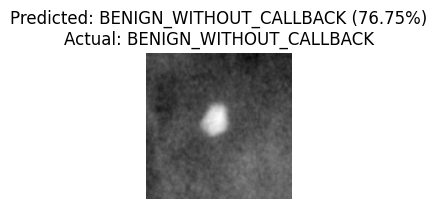

Calc Test 2    Predicted: BENIGN_WITHOUT_CALLBACK (76.75%)    Actual: BENIGN_WITHOUT_CALLBACK
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


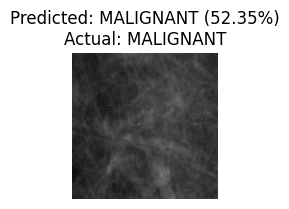

Calc Test 3    Predicted: MALIGNANT (52.35%)    Actual: MALIGNANT


<Figure size 640x480 with 0 Axes>

In [56]:
print("\nMaking predictions on calcification test images...")
calc_benign_path = os.path.join(data_dir, 'calcification/test/cropped_files/BENIGN/1-000.jpg')
calc_bwc_path = os.path.join(data_dir, 'calcification/test/cropped_files/BENIGN_WITHOUT_CALLBACK/1-001.jpg')
calc_malignant_path = os.path.join(data_dir, 'calcification/test/cropped_files/MALIGNANT/1-011.jpg')

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
predicted_class, confidence = predict_and_display(calc_model, calc_benign_path, "BENIGN")
print(f"Calc Test 1    Predicted: {predicted_class} ({confidence:.2f}%)    Actual: BENIGN")

plt.subplot(1, 3, 2)
predicted_class, confidence = predict_and_display(calc_model, calc_bwc_path, "BENIGN_WITHOUT_CALLBACK")
print(f"Calc Test 2    Predicted: {predicted_class} ({confidence:.2f}%)    Actual: BENIGN_WITHOUT_CALLBACK")

plt.subplot(1, 3, 3)
predicted_class, confidence = predict_and_display(calc_model, calc_malignant_path, "MALIGNANT")
print(f"Calc Test 3    Predicted: {predicted_class} ({confidence:.2f}%)    Actual: MALIGNANT")

plt.tight_layout()
plt.show()